# py4DSTEM tutorial 5: Find the lattice vectors

This step gets an initial guess at the lattice vectors, using the corrected Bragg vector map.

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import radon

from py4DSTEM.file.datastructure import PointList
from py4DSTEM.file.io import FileBrowser, read, append

from py4DSTEM.process.latticevectors import get_radon_scores, get_lattice_directions_from_scores, get_lattice_vector_lengths

In [2]:
# Load data

fp = "/Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/sample_processing_file2.h5"
dc = py4DSTEM.file.io.read(fp)                                                # Get the datacube

fp = "/Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/Sample_LFP_datacube_processing.h5"
browser = FileBrowser(fp)
# braggpeaks = browser.get_dataobject('braggpeaks_shifted')
braggpeaks = browser.get_dataobject('braggpeaks')
braggvectormap = browser.get_dataobject('braggvectormap_shiftcorrected').data
browser.close()

/Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/sample_processing_file2.h5 is a py4DSTEM file, v0.6. Reading...


In [24]:
browser.close()

### Take radon transform of Bragg vector map

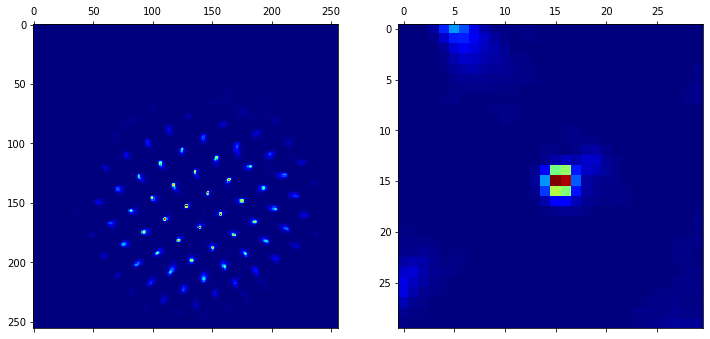

In [3]:
# Show Bragg vector map

power=0.4

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,sigma=2)),(dc.Q_Nx,dc.Q_Ny))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(braggvectormap**power,cmap='jet')
ax2.matshow(braggvectormap[x0-15:x0+15,y0-15:y0+15]**power,cmap='jet')
plt.show()

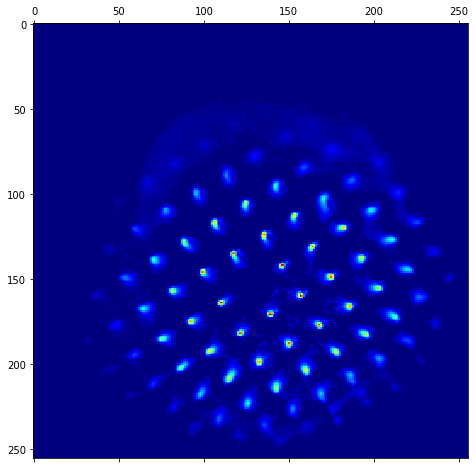

In [4]:
# Get mask for unscattered beam

maskrad = 10
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,sigma=2)),(dc.Q_Nx,dc.Q_Ny))
ry,rx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
mask = ((rx-x0)**2+(ry-y0)**2) > maskrad**2

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow((braggvectormap*mask)**power,cmap='jet')
plt.show()

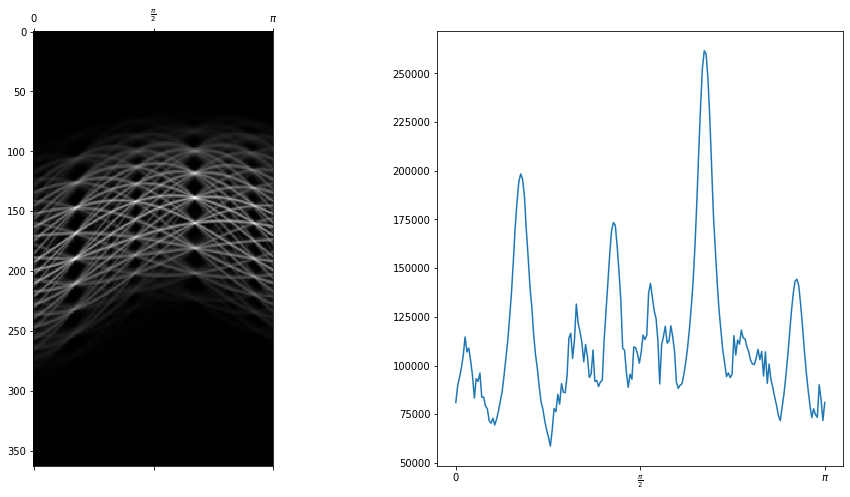

In [5]:
# Get scores

N_angles = 200
sigma = 2
minSpacing = 10
minRelativeIntensity = 0.05

power = 0.5

scores, thetas, sinogram = get_radon_scores(braggvectormap, mask, N_angles, sigma, minSpacing, minRelativeIntensity)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

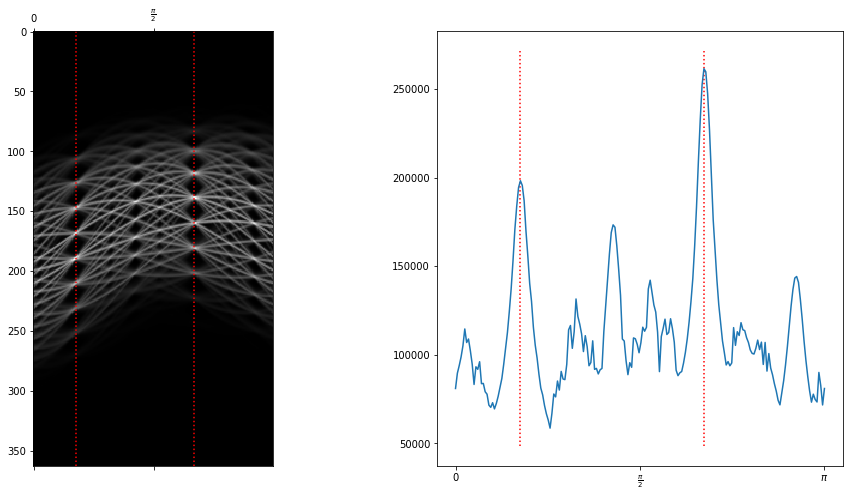

Initial guess at u and v angles is 121.2 and 31.66, respectively.


In [6]:
# Get lattice directions

sigma = 2
minSpacing = 10
minRelativeIntensity = 0.05
index1 = 0
index2 = 0

power = 0.5

u_theta, v_theta = get_lattice_directions_from_scores(thetas, scores, sigma, minSpacing, minRelativeIntensity,
                                                                                         index1, index2)

u_theta_ind = np.argmin(np.abs(thetas-u_theta))
v_theta_ind = np.argmin(np.abs(thetas-v_theta))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.vlines((u_theta_ind,v_theta_ind),ax1.get_ylim()[0],ax1.get_ylim()[1],linestyle=":",color='r')
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.vlines((u_theta,v_theta),ax2.get_ylim()[0],ax2.get_ylim()[1],linestyle=":",color='r')
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

print("Initial guess at u and v angles is {:.4} and {:.4}, respectively.".format(np.degrees(u_theta),np.degrees(v_theta)))

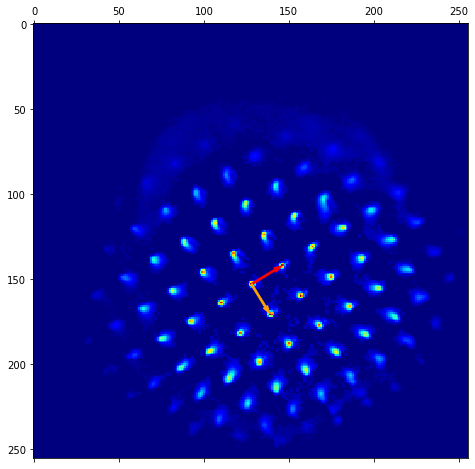

In [8]:
# Get lattice vector lengths

spacing_thresh = 1.5
sigma = 2
minSpacing = 2
minRelativeIntensity = 0.1

power = 0.25

u_length, v_length = get_lattice_vector_lengths(u_theta, v_theta, thetas, sinogram,
                                                spacing_thresh, sigma, minSpacing, minRelativeIntensity)

# Show
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,sigma=2)),(dc.Q_Nx,dc.Q_Ny))
u_dx = np.cos(u_theta)*u_length
u_dy = np.sin(u_theta)*u_length
v_dx = np.cos(v_theta)*v_length
v_dy = np.sin(v_theta)*v_length

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**power,cmap='jet')
ax.arrow(y0,x0,u_dy,u_dx, color='red',width=1,length_includes_head=True)
ax.arrow(y0,x0,v_dy,v_dx, color='orange',width=1,length_includes_head=True)
plt.show()

### Save lattice vectors

In [9]:
# Make pointlist

coordinates = [('qx',float),('qy',float)]
lattice_vectors = PointList(coordinates, name='lattice_vectors')
lattice_vectors.add_point((u_dx,u_dy))
lattice_vectors.add_point((v_dx,v_dy))

In [10]:
# Append to processing file

fp = "/Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/Sample_LFP_datacube_processing.h5"
append(lattice_vectors, fp)

Opening file /Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/Sample_LFP_datacube_processing.h5...
Done.
